In [1]:
%matplotlib inline

## [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
- Builds clusters by separating samples into groups of equal variance - minimizing an "inertia" criterion (ie, within-cluster sum-of-squares, $\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$). The number of clusters is given.
- It returns K disjoint clusters, each described by the mean of the samples in the cluster (aka "centroids")
- Inertia can be described as a cluster's internal coherence. It has some drawbacks:
    - It assumes clusters are convex and [isotropic](https://en.wikipedia.org/wiki/Isotropy). It responds poorly to elongated clusters, or irregular manifolds.
    - It is not a normalized metric and suffers when Euclidean distances become inflated due to high-D characteristics (aka the curse of dimensionality). Using dimensionality reduction prior to clustering can help.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

n_samples    = 1500
random_state = 170


Text(0.5, 1.0, 'Incorrect Number of Blobs')

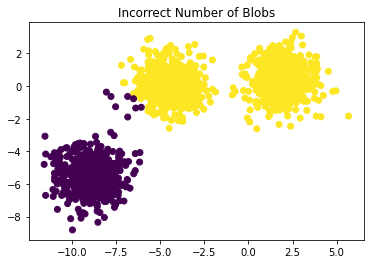

In [9]:
X, y   = make_blobs(n_samples    = n_samples, 
                    random_state = random_state)
y_pred = KMeans(n_clusters       = 2, 
                random_state     = random_state).fit_predict(X)
#plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

Text(0.5, 1.0, 'Anisotropicly Distributed Blobs')

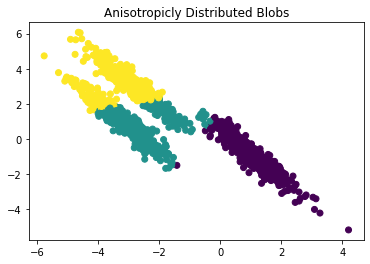

In [10]:
# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso        = np.dot(X, transformation)
y_pred         = KMeans(n_clusters   = 3, 
                        random_state = random_state).fit_predict(X_aniso)

#plt.subplot(222)
plt.scatter(X_aniso[:, 0], 
            X_aniso[:, 1], 
            c = y_pred)
plt.title("Anisotropicly Distributed Blobs")

Text(0.5, 1.0, 'Unequal Variance')

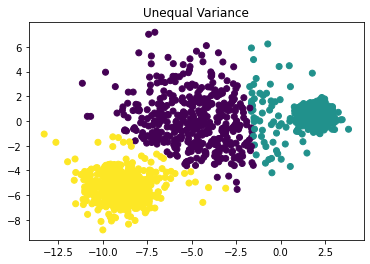

In [11]:
# Different variance
X_varied, y_varied = make_blobs(n_samples    = n_samples,
                                cluster_std  = [1.0, 2.5, 0.5],
                                random_state = random_state)
y_pred = KMeans(n_clusters   = 3, 
                random_state = random_state).fit_predict(X_varied)

#plt.subplot(223)
plt.scatter(X_varied[:, 0], 
            X_varied[:, 1], 
            c = y_pred)
plt.title("Unequal Variance")

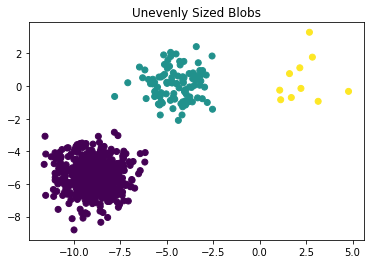

In [12]:
# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], 
                        X[y == 1][:100], 
                        X[y == 2][:10]))
y_pred = KMeans(n_clusters = 3,
                random_state = random_state).fit_predict(X_filtered)

#plt.subplot(224)
plt.scatter(X_filtered[:, 0], 
            X_filtered[:, 1], 
            c = y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

## Background
- K-means often referred to a Lloyd's algorithm
- IDs initial set of centroids, assigns each sample to nearest centroid, then creates new centroids by finding the mean of all samples assigned to existing centroid.
- Algorithm repeats until difference(old centroid, new centroid) falls below a given threshold.
- Given enough time, K-means always converges to a local minimum. This depends on the initial choice of centroids. Using ```init='k-means'``` helps this issue by initializing centroids to be equidistant from each other.
- K-Means supports sample weights via ```sample_weight```. This assigns more weight to some samples when finding cluster centers and intertia values.

## Voronoi Diagrams

In [13]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits    = load_digits(return_X_y=True)
data                  = scale(X_digits)
n_samples, n_features = data.shape
n_digits              = len(np.unique(y_digits))
labels                = y_digits
sample_size           = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))

n_digits: 10, 	 n_samples 1797, 	 n_features 64


In [14]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(         labels, estimator.labels_),
             metrics.completeness_score(        labels, estimator.labels_),
             metrics.v_measure_score(           labels, estimator.labels_),
             metrics.adjusted_rand_score(       labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels, estimator.labels_),
             metrics.silhouette_score(          data,   estimator.labels_,
                                                metric='euclidean',
                                                sample_size=sample_size)))

bench_k_means(KMeans(init       = 'k-means++', 
                     n_clusters = n_digits, 
                     n_init     = 10),
                     name       = "k-means++", 
                     data       = data)

bench_k_means(KMeans(init       = 'random', 
                     n_clusters = n_digits, 
                     n_init     = 10),
                     name       = "random", 
                     data       = data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1

pca = PCA(n_components=n_digits).fit(data)

bench_k_means(KMeans(init       = pca.components_, 
                     n_clusters = n_digits, 
                     n_init     = 1),
              name = "PCA-based",
              data = data)


k-means++	1.85s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.39s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.15s	70768	0.668	0.695	0.681	0.558	0.678	0.142


In [15]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans       = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

KMeans(n_clusters=10)

/home/bjpcjp/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/bjpcjp/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


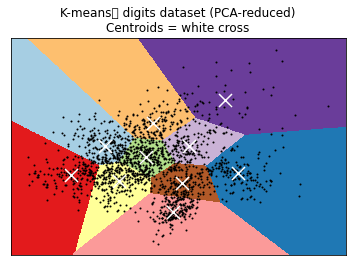

In [16]:
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                     np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap   = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

plt.plot(reduced_data[:, 0], 
         reduced_data[:, 1], 
         'k.', 
         markersize=2)

# Plot centroids with white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], 
            centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

plt.title('K-means\t digits dataset (PCA-reduced)\n'
          'Centroids = white cross')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## [K-Means (MiniBatch)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans)
- Uses minibatches (randomly sampled subsets of training data) to reduce computation time. Results are generally only slightly worse than the std algorithm.

## Example: K-Means vs K-Means Minibatch

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

In [18]:
np.random.seed(0)
batch_size     = 45
centers        = [[1, 1], [-1, -1], [1, -1]]
n_clusters     = len(centers)
X, labels_true = make_blobs(n_samples   = 3000, 
                            centers     = centers, 
                            cluster_std = 0.7)

k_means = KMeans(init       = 'k-means++', 
                 n_clusters = 3, 
                 n_init     = 10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

mbk = MiniBatchKMeans(init               = 'k-means++', 
                      n_clusters         = 3, 
                      batch_size         = batch_size,
                      n_init             = 10, 
                      max_no_improvement = 10, 
                      verbose            = 0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0


In [21]:
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

k_means_cluster_centers = k_means.cluster_centers_

order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)

mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels   = pairwise_distances_argmin(X,   k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)


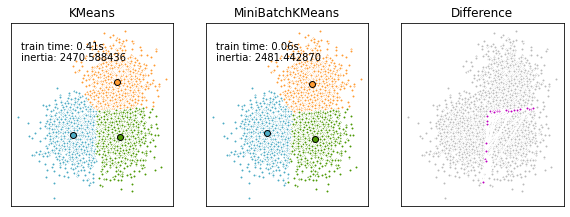

In [22]:
fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()